In [1]:
import jax
jax.config.update("jax_default_device",jax.devices()[1])
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax import jit,grad,jacfwd,jacrev,vmap
import numpy as np
import matplotlib.pyplot as plt
import jax
from tqdm.auto import tqdm
plt.style.use("ggplot")

from importlib import reload
#import keql_tools
#reload(keql_tools)
#from keql_tools import *
from Kernels import *
from EquationModel import *
from jax.scipy.linalg import solve
from EquationModel import *
from GP_sampler import *
from plotting import *
from evaluation_metrics import *

import LM_Solve
import importlib
importlib.reload(LM_Solve)
from LM_Solve import LevenbergMarquadtMinimize

from LM_Solve import adaptive_refine_solution

/home/josorior/miniconda3/envs/myjaxenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Utils

In [2]:
## Utils
# Build interior and boundary grids
def build_xy_grid(x_range,y_range,num_grid_x,num_grid_y):
    full_x_grid = jnp.linspace(x_range[0],x_range[1],num_grid_x)
    full_y_grid = jnp.linspace(y_range[0],y_range[1],num_grid_y)

    x_interior = full_x_grid[1:-1]
    y_interior = full_y_grid[1:-1]
    
    x_boundary = full_x_grid[jnp.array([0,-1])]
    y_boundary = full_y_grid[jnp.array([0,-1])]

    #Get interior points
    x,y = jnp.meshgrid(x_interior,y_interior)
    xy_interior = jnp.vstack([x.flatten(),y.flatten()]).T

    #I'm doing this with meshgrid to handle more general higher dimensions, ie circular domain in 2d
    #Get boundary points
    x,y = jnp.meshgrid(x_interior,y_boundary)
    xy_boundary_1 = jnp.vstack([x.flatten(),y.flatten()]).T

    x,y = jnp.meshgrid(x_boundary,y_interior)
    xy_boundary_2 = jnp.vstack([x.flatten(),y.flatten()]).T

    x,y = jnp.meshgrid(x_boundary,y_boundary)
    xy_boundary_3 = jnp.vstack([x.flatten(),y.flatten()]).T

    xy_boundary = jnp.vstack([xy_boundary_1,xy_boundary_2,xy_boundary_3])
    return xy_interior,xy_boundary

In [3]:
def get_obs(num_obs, xy_int, xy_bdy,vmapped_u_true_functions, vmapped_rhs, seed):
    """
        Gets samples(functions) of GP. 

        Args:
            num_obs (list): List of integers of number of observed points per function.
            xy_int (jnp.array): Interior domain to get the sample.
            xy_bdy (jnp.array): Boundary domain.
            vmapped_u_true_functions (list): List of vmapped u true functions.
            vmapped_u_true_functions (list): List of vmapped f true functions.
            seed (int): Integer to fix the simulation.

        Returns:
            list: List of lists xy_obs, u_obs, f_obs.   
    """

    if len(num_obs) != len(vmapped_u_true_functions):
        raise Exception("len of list of provided observed points not same as len of list of provided functions.")
    
    num_f = len(vmapped_rhs)
    key = jax.random.PRNGKey(seed)
    seed = jax.random.randint(key=key, shape=(num_f,), minval=1, maxval=40)
    xy_obs, u_obs, f_obs =  [], [], []
    for i, num_ob in enumerate(num_obs):
        np.random.seed(seed[i])
        xy_sample_indsi = np.random.choice(list(np.arange(len(xy_int))),num_ob,replace = False)
        xy_obsi = jnp.vstack([xy_bdy,xy_int[xy_sample_indsi]])
        xy_obs.append(xy_obsi)
        u_obs.append(vmapped_u_true_functions[i](xy_obsi))
        f_obs.append(vmapped_rhs[i](xy_obsi))
    return xy_obs, u_obs, f_obs

In [4]:
# Build operator features
def diff_x_op(k,index):
    return get_selected_grad(k,index,0)

def diff_xx_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,0),index,0)

def diff_y_op(k,index):
    return get_selected_grad(k,index,1)

def diff_yy_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,1),index,1)

def diff_xy_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,0),index,1)

feature_operators = tuple([eval_k,diff_x_op,diff_xx_op,diff_y_op,diff_yy_op,diff_xy_op])

In [5]:
def run_exp(m, obs_pts,run):
    # Define grid to get samples from GP
    x_grid=jnp.linspace(0,1,25)
    y_grid=jnp.linspace(0,1,25)
    X,Y=jnp.meshgrid(x_grid,y_grid)
    pairs = jnp.vstack([X.ravel(), Y.ravel()]).T

    # Sample m training functions from a GP
    kernel_GP = get_gaussianRBF(0.5)
    u_true_functions = tuple(GP_sampler(num_samples = m,
                                            X = pairs, 
                                            kernel = kernel_GP,
                                            reg = 1e-12,
                                            seed = run
                                        )  
                                        )

    # Permeability field A
    def A(xy):
        x = xy[0]
        y = xy[1]
        return jnp.exp(2*(jnp.sin(jnp.cos(2*x) + jnp.cos(2*y))))

    # Compute f = Pu for any u
    def get_rhs_darcy(u):
        def Agradu(xy):
            return A(xy)*jax.grad(u)(xy)
        def Pu(xy):
            return jnp.trace(jax.jacfwd(Agradu)(xy))
        return Pu

    # Lists of m true u's and f's
    vmapped_u_true_functions = tuple([jax.vmap(u) for u in u_true_functions]) # vmap'ed
    rhs_functions = tuple([jax.vmap(get_rhs_darcy(u)) for u in u_true_functions]) #vmap'ed

    # Define the num of ghost points for each u
    num_grid_points = 8
    # Ghost grid - Same per function
    xy_int,xy_bdy = build_xy_grid([0,1],[0,1],num_grid_points,num_grid_points)
    xy_all = jnp.vstack([xy_bdy,xy_int])

    # Number of observed points per u
    num_obs = [obs_pts]*m

    xy_obs, u_obs, f_obs = get_obs(num_obs, xy_int, xy_bdy,vmapped_u_true_functions, rhs_functions, seed=2024)

    # Build interpolants for u's
    k_u = get_gaussianRBF(0.5)
    u_models = tuple([InducedRKHS(
        xy_all,
        feature_operators,
        k_u
        ) for i in range(m)])
    
    # Get necessary tuples
    observation_points = tuple(xy_obs)
    observation_values = tuple(u_obs)
    collocation_points = (xy_int,)*m

    rhs_values = tuple(rhs_func(xy_int) for rhs_func in rhs_functions)

    all_u_params_init = tuple([model.get_fitted_params(obs_loc,obs_val) for obs_loc,obs_val,model in zip(observation_points,observation_values,u_models)])

    grid_features_u_init = jnp.vstack([(model.evaluate_operators(feature_operators,xy_int,model_params)).reshape(
                len(xy_int),
                len(feature_operators),
                order = 'F'
            ) for model,model_params in zip(u_models,all_u_params_init) ])


    k_P_u_part = get_centered_scaled_poly_kernel(2,grid_features_u_init,c=1)
    k_P_x_part = get_gaussianRBF(0.4)
    def k_P(x,y):
        return k_P_x_part(x[:2],y[:2]) * k_P_u_part(x[2:],y[2:])
    

    class P_model():

        kernel_function = jit(
            get_kernel_block_ops(k_P,[eval_k],[eval_k])
        )

        num_params = len(grid_features_u_init)

        @jit
        def predict(input_data,params):
            K = P_model.kernel_function(input_data,input_data)
            return K@params
        
        def get_P_eval(input_data,params):
            def predict(prediction_points):
                K = P_model.kernel_function(prediction_points,input_data)
                return K@params
            return predict
        
    collocation_points = tuple([xy_int]*m)
    
    EqnModel  = OperatorPDEModel(
        P_model,
        u_models,
        observation_points,
        observation_values,
        collocation_points,
        feature_operators,
        rhs_values,
        datafit_weight = 5.,
    )

    params_init = jnp.hstack(list(all_u_params_init)+[jnp.zeros(m*len(xy_int))])

    params,loss_vals,JtRes,improvement_ratios,alpha_vals,iterate_history = LevenbergMarquadtMinimize(
        params_init.copy(),
        EqnModel,
        beta = 1e-8,
        max_iter = 501,
        init_alpha=3,
        line_search_increase_ratio=2.
    )

    p_adjusted,refinement_losses,reg_sequence = adaptive_refine_solution(params,EqnModel,1e-1,500)

    u_sols = EqnModel.get_u_params(p_adjusted)
    P_sol = EqnModel.get_P_params(p_adjusted)

    # Testing grid
    num_fine_grid = 50
    x_fine,y_fine = np.meshgrid(np.linspace(0,1,num_fine_grid+4)[2:-2],np.linspace(0,1,num_fine_grid+4)[2:-2])
    xy_fine_int = np.vstack([x_fine.flatten(),y_fine.flatten()]).T

    # Estimated P from 1.5 step method
    model_grid_features_all = EqnModel.get_stacked_eqn_features(u_sols)    
    S_train = model_grid_features_all
    P_func = P_model.get_P_eval(S_train,P_sol)

    # Estimated P from 2 step method
    init_P_features = EqnModel.get_stacked_eqn_features(all_u_params_init)
    S_train_2 = init_P_features 
    K = P_model.kernel_function(S_train_2,S_train_2)
    P_params_naive = solve(K+1e-5*diagpart(K),EqnModel.stacked_collocation_rhs)
    P_func2 = P_model.get_P_eval(S_train_2,P_params_naive)

    # P[\phi(w)](fine_grid)
    def evaluate_hatP(P_func, w, fine_grid, feature_operators):

        # Build S_test
        w_features = jnp.array([jax.vmap(operator(w,0))(xy_fine_int) for operator in feature_operators]).T
        model_fine_features = jnp.hstack([fine_grid, w_features])
        S_test = model_fine_features


        #P_preds_model_features = P_model.kernel_function(S_test,S_train)@P_sol 
        P_preds = P_func(S_test)
        return P_preds
    
    ########### Errors ################
    
    # In sample

    # Get list of approximated functions ^U = [^u_1, ^u_2, ^u_3]
    true = [f(xy_fine_int) for f in rhs_functions]

    u_approx_funcs = [u_models[ind].get_eval_function(u_sols[ind]) 
                    for ind in range(m)]
    pred1_5 = [
        evaluate_hatP(
        P_func,
        u, xy_fine_int,feature_operators) for u in u_approx_funcs
    ]

    twostep_u_approx_funcs = [u_models[ind].get_eval_function(all_u_params_init[ind]) 
                    for ind in range(m)]
    pred2 = [
        evaluate_hatP(
        P_func2,
        u, xy_fine_int,feature_operators) for u in twostep_u_approx_funcs
    ]
    i_smpl_1_5 = jnp.mean(jnp.array([get_nrmse(t,p) for t,p in zip(true,pred1_5)])) # RMSE
    i_smpl_2 = jnp.mean(jnp.array([get_nrmse(t,p) for t,p in zip(true,pred2)]))



    # In distribution

    M = 50
    kernel_GP = get_gaussianRBF(0.5)
    # Sample M training functions from GP(0,K)
    w_train_functions = GP_sampler(num_samples = M,
                    X = pairs, 
                    kernel = kernel_GP,
                    reg = 1e-12,
                    seed = run
                    )
    vmapped_w_train_functions = tuple([jax.vmap(w) for w in w_train_functions]) # vmap'ed
    w_rhs_functions = tuple([jax.vmap(get_rhs_darcy(w)) for w in w_train_functions]) #vmap'ed

    # mean 
    true = [f_w(xy_fine_int) for f_w in w_rhs_functions]
    #pred = [evaluate_hatP(w, xy_fine_int, u_sols, P_sol,feature_operators) for w in w_test_functions]
    pred1_5 = [
        evaluate_hatP(
        lambda x:P_model.kernel_function(x,S_train)@P_sol,
        w, xy_fine_int,feature_operators) for w in w_train_functions
    ]

    pred2 = [
        evaluate_hatP(
        P_func2,
        u, xy_fine_int,feature_operators) for u in w_train_functions
    ]

    i_dis_1_5 = jnp.mean(jnp.array([get_nrmse(t,p) for t,p in zip(true,pred1_5)]))
    i_dis_2 = jnp.mean(jnp.array([get_nrmse(t,p) for t,p in zip(true,pred2)]))


    

    # Out of sample
    M = 50
    kernel_GP = get_gaussianRBF(0.2)
    # Sample M test functions from GP(0,K)
    w_test_functions = GP_sampler(num_samples = M,
                    X = pairs, 
                    kernel = kernel_GP,
                    reg = 1e-12,
                    seed = run
                    )
    vmapped_w_test_functions = tuple([jax.vmap(w) for w in w_test_functions]) # vmap'ed
    w_rhs_functions = tuple([jax.vmap(get_rhs_darcy(w)) for w in w_test_functions]) #vmap'ed

    # mean 
    true = [f_w(xy_fine_int) for f_w in w_rhs_functions]
    #pred = [evaluate_hatP(w, xy_fine_int, u_sols, P_sol,feature_operators) for w in w_test_functions]
    pred1_5 = [
        evaluate_hatP(
        lambda x:P_model.kernel_function(x,S_train)@P_sol,
        w, xy_fine_int,feature_operators) for w in w_test_functions
    ]

    pred2 = [
        evaluate_hatP(
        P_func2,
        u, xy_fine_int,feature_operators) for u in w_test_functions
    ]

    o_dis_1_5 = jnp.mean(jnp.array([get_nrmse(t,p) for t,p in zip(true,pred1_5)]))
    o_dis_2 = jnp.mean(jnp.array([get_nrmse(t,p) for t,p in zip(true,pred2)]))

    return i_dis_1_5, i_dis_2, o_dis_1_5, o_dis_2, i_smpl_1_5, i_smpl_2

## Structure to store the errors

We create a dictionary called `err` to store errors (nrmse) where we denote the keys as follows:

>  `1_5_mthd`: This is the main algorithm.

>  `2_obs`: This means that its parent method was trained using the observed functions at 2 points.

>  `i_dis`: List of list which contains the errors for P at the training functions.

>  `o_dis`: List of list which contains the errors for P at the testing functions.

In [6]:
err = {
    '1_5_mthd': {
        '2_obs': {'i_dis': [],'o_dis': [], 'i_smpl' : []},
        '4_obs': {'i_dis': [],'o_dis': [], 'i_smpl' : []},
        '8_obs': {'i_dis': [],'o_dis': [], 'i_smpl' : []}
                  },
    '2_mthd':   {
        '2_obs': {'i_dis': [],'o_dis': [], 'i_smpl' : []},
        '4_obs': {'i_dis': [],'o_dis': [], 'i_smpl' : []},
        '8_obs': {'i_dis': [],'o_dis': [], 'i_smpl' : []}
                }
}

In [7]:
NUM_FUN_LIST = [2,4,8,16]
NUM_RUNS = 1
OBS_PTS_LIST = [2,4,8]

for obs_pt in OBS_PTS_LIST:
    for m in NUM_FUN_LIST:
        i_dis_1_5 = []
        i_dis_2 = []
        o_dis_1_5 = []
        o_dis_2 = []
        i_smpl_1_5 = []
        i_smpl_2 = []
        for run in range(NUM_RUNS):
            # Run
            res = run_exp(m, obs_pt, run)
            # Append
            i_dis_1_5.append(res[0])
            i_dis_2.append(res[1])
            o_dis_1_5.append(res[2])
            o_dis_2.append(res[3])
            i_smpl_1_5.append(res[4])
            i_smpl_2.append(res[5])
        # Append each list    
        err['1_5_mthd'][f'{obs_pt}_obs']['i_dis'].append(i_dis_1_5)
        err['2_mthd'][f'{obs_pt}_obs']['i_dis'].append(i_dis_2)
        err['1_5_mthd'][f'{obs_pt}_obs']['o_dis'].append(o_dis_1_5)
        err['2_mthd'][f'{obs_pt}_obs']['o_dis'].append(o_dis_2)
        err['1_5_mthd'][f'{obs_pt}_obs']['i_smpl'].append(i_smpl_1_5)
        err['2_mthd'][f'{obs_pt}_obs']['i_smpl'].append(i_smpl_2)    
    # Save after 
    jnp.save('errors/err', err)

  2%|▏         | 11/501 [00:00<00:14, 33.26it/s]

Iteration 0, loss = 895.7, Jres = 2.963e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 808.1, Jres = 3.73e+04, alpha = 48.0, improvement_ratio = 0.1251
Iteration 2, loss = 80.66, Jres = 1.449e+05, alpha = 16.67, improvement_ratio = 0.9352
Iteration 3, loss = 18.77, Jres = 2.825e+04, alpha = 13.89, improvement_ratio = 0.9783
Iteration 4, loss = 13.07, Jres = 3.69e+03, alpha = 11.57, improvement_ratio = 1.002
Iteration 5, loss = 10.15, Jres = 443.0, alpha = 9.645, improvement_ratio = 1.011


 14%|█▍        | 72/501 [00:00<00:02, 145.89it/s]

Iteration 50, loss = 0.01793, Jres = 27.78, alpha = 0.003165, improvement_ratio = 0.8394


 27%|██▋       | 137/501 [00:01<00:01, 188.79it/s]

Iteration 100, loss = 0.000627, Jres = 7.731, alpha = 0.0002958, improvement_ratio = 0.7513


 36%|███▌      | 179/501 [00:01<00:01, 199.08it/s]

Iteration 150, loss = 3.577e-05, Jres = 0.7416, alpha = 3.981e-05, improvement_ratio = 0.7823


 45%|████▍     | 223/501 [00:01<00:01, 206.36it/s]

Iteration 200, loss = 1.124e-05, Jres = 0.2712, alpha = 5.358e-06, improvement_ratio = 0.7889


 58%|█████▊    | 289/501 [00:01<00:01, 209.90it/s]

Iteration 250, loss = 1.022e-05, Jres = 0.3506, alpha = 4.465e-06, improvement_ratio = 0.6273


 67%|██████▋   | 335/501 [00:01<00:00, 217.64it/s]

Iteration 300, loss = 9.82e-06, Jres = 0.3493, alpha = 4.465e-06, improvement_ratio = 0.5856


 76%|███████▌  | 381/501 [00:02<00:00, 221.15it/s]

Iteration 350, loss = 9.511e-06, Jres = 0.3506, alpha = 4.465e-06, improvement_ratio = 0.561


 85%|████████▌ | 427/501 [00:02<00:00, 223.19it/s]

Iteration 400, loss = 9.25e-06, Jres = 0.3546, alpha = 4.465e-06, improvement_ratio = 0.5345


 99%|█████████▉| 496/501 [00:02<00:00, 223.60it/s]

Iteration 450, loss = 9.029e-06, Jres = 0.3598, alpha = 4.465e-06, improvement_ratio = 0.5061


100%|██████████| 501/501 [00:02<00:00, 186.04it/s]


Iteration 500, loss = 8.84e-06, Jres = 0.3649, alpha = 4.465e-06, improvement_ratio = 0.4777


  1%|▏         | 7/501 [00:00<00:17, 28.77it/s]

Iteration 0, loss = 607.9, Jres = 2.372e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 495.7, Jres = 1.506e+04, alpha = 20.0, improvement_ratio = 0.2313
Iteration 2, loss = 60.35, Jres = 6.136e+04, alpha = 16.67, improvement_ratio = 0.9368
Iteration 3, loss = 28.48, Jres = 9.162e+03, alpha = 13.89, improvement_ratio = 0.9736
Iteration 4, loss = 21.33, Jres = 1.008e+03, alpha = 11.57, improvement_ratio = 1.015
Iteration 5, loss = 16.58, Jres = 224.6, alpha = 9.645, improvement_ratio = 1.03


 13%|█▎        | 63/501 [00:01<00:05, 73.00it/s]

Iteration 50, loss = 0.01587, Jres = 20.42, alpha = 0.002637, improvement_ratio = 0.8342


 22%|██▏       | 111/501 [00:01<00:05, 76.33it/s]

Iteration 100, loss = 0.0009914, Jres = 9.332, alpha = 0.0002054, improvement_ratio = 0.7469


 32%|███▏      | 159/501 [00:02<00:04, 76.59it/s]

Iteration 150, loss = 0.0001135, Jres = 2.581, alpha = 5.732e-05, improvement_ratio = 0.7687


 43%|████▎     | 215/501 [00:03<00:03, 76.20it/s]

Iteration 200, loss = 2.859e-05, Jres = 0.9355, alpha = 1.92e-05, improvement_ratio = 0.6747


 52%|█████▏    | 263/501 [00:03<00:03, 76.60it/s]

Iteration 250, loss = 1.64e-05, Jres = 0.2507, alpha = 7.715e-06, improvement_ratio = 0.7671


 62%|██████▏   | 311/501 [00:04<00:02, 78.06it/s]

Iteration 300, loss = 1.449e-05, Jres = 0.3169, alpha = 4.465e-06, improvement_ratio = 0.7172


 72%|███████▏  | 359/501 [00:04<00:01, 76.55it/s]

Iteration 350, loss = 1.366e-05, Jres = 0.2176, alpha = 3.101e-06, improvement_ratio = 0.7507


 83%|████████▎ | 415/501 [00:05<00:01, 76.24it/s]

Iteration 400, loss = 1.314e-05, Jres = 0.1215, alpha = 2.153e-06, improvement_ratio = 0.7177


 92%|█████████▏| 463/501 [00:06<00:00, 76.07it/s]

Iteration 450, loss = 1.282e-05, Jres = 0.05955, alpha = 2.153e-06, improvement_ratio = 0.7586


100%|██████████| 501/501 [00:06<00:00, 74.28it/s]


Iteration 500, loss = 1.26e-05, Jres = 0.06521, alpha = 2.153e-06, improvement_ratio = 0.7598


  0%|          | 2/501 [00:00<01:19,  6.25it/s]

Iteration 0, loss = 577.1, Jres = 2.898e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 515.9, Jres = 7.279e+03, alpha = 12.0, improvement_ratio = 0.1424
Iteration 2, loss = 66.53, Jres = 5.723e+04, alpha = 10.0, improvement_ratio = 0.9662


  1%|          | 6/501 [00:00<00:37, 13.09it/s]

Iteration 3, loss = 31.51, Jres = 5.516e+03, alpha = 8.333, improvement_ratio = 1.01
Iteration 4, loss = 20.46, Jres = 1.066e+03, alpha = 6.944, improvement_ratio = 1.044
Iteration 5, loss = 14.2, Jres = 238.3, alpha = 5.787, improvement_ratio = 1.043


 11%|█         | 54/501 [00:03<00:24, 18.22it/s]

Iteration 50, loss = 0.02061, Jres = 72.12, alpha = 0.001899, improvement_ratio = 0.8086


 21%|██        | 104/501 [00:05<00:21, 18.27it/s]

Iteration 100, loss = 0.001193, Jres = 4.85, alpha = 0.000213, improvement_ratio = 0.6999


 31%|███       | 154/501 [00:08<00:19, 18.23it/s]

Iteration 150, loss = 0.0002379, Jres = 5.07, alpha = 5.943e-05, improvement_ratio = 0.7622


 41%|████      | 204/501 [00:11<00:16, 18.22it/s]

Iteration 200, loss = 8.137e-05, Jres = 2.609, alpha = 2.389e-05, improvement_ratio = 0.7517


 51%|█████     | 254/501 [00:14<00:13, 18.24it/s]

Iteration 250, loss = 4.208e-05, Jres = 1.6, alpha = 1.659e-05, improvement_ratio = 0.7868


 61%|██████    | 304/501 [00:16<00:10, 18.21it/s]

Iteration 300, loss = 2.901e-05, Jres = 1.064, alpha = 7.999e-06, improvement_ratio = 0.7615


 71%|███████   | 354/501 [00:19<00:08, 18.28it/s]

Iteration 350, loss = 2.382e-05, Jres = 0.5636, alpha = 3.858e-06, improvement_ratio = 0.7477


 81%|████████  | 404/501 [00:22<00:05, 18.28it/s]

Iteration 400, loss = 2.218e-05, Jres = 0.1367, alpha = 2.232e-06, improvement_ratio = 0.7934


 91%|█████████ | 454/501 [00:25<00:02, 18.25it/s]

Iteration 450, loss = 2.163e-05, Jres = 0.2385, alpha = 1.86e-06, improvement_ratio = 0.694


100%|██████████| 501/501 [00:27<00:00, 18.09it/s]


Iteration 500, loss = 2.139e-05, Jres = 0.1972, alpha = 1.86e-06, improvement_ratio = 0.7269


  0%|          | 1/501 [00:00<04:37,  1.80it/s]

Iteration 0, loss = 884.7, Jres = 5.098e+03, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:01<04:11,  1.99it/s]

Iteration 1, loss = 585.4, Jres = 9.376e+03, alpha = 5.0, improvement_ratio = 0.4197


  1%|          | 3/501 [00:01<03:27,  2.40it/s]

Iteration 2, loss = 70.64, Jres = 2.895e+04, alpha = 4.167, improvement_ratio = 0.9516


  1%|          | 4/501 [00:01<03:07,  2.66it/s]

Iteration 3, loss = 33.12, Jres = 4.213e+03, alpha = 3.472, improvement_ratio = 1.002


  1%|          | 5/501 [00:01<02:55,  2.82it/s]

Iteration 4, loss = 22.22, Jres = 522.4, alpha = 2.894, improvement_ratio = 1.032


  1%|          | 6/501 [00:02<02:48,  2.94it/s]

Iteration 5, loss = 16.47, Jres = 173.8, alpha = 2.411, improvement_ratio = 1.021


 10%|█         | 51/501 [00:16<02:21,  3.18it/s]

Iteration 50, loss = 0.02899, Jres = 34.2, alpha = 0.001367, improvement_ratio = 0.6626


 20%|██        | 101/501 [00:32<02:05,  3.18it/s]

Iteration 100, loss = 0.003315, Jres = 17.63, alpha = 0.0002208, improvement_ratio = 0.7599


 30%|███       | 151/501 [00:47<01:50,  3.18it/s]

Iteration 150, loss = 0.001199, Jres = 26.7, alpha = 8.874e-05, improvement_ratio = 0.7233


 40%|████      | 201/501 [01:03<01:34,  3.18it/s]

Iteration 200, loss = 0.000538, Jres = 7.452, alpha = 3.566e-05, improvement_ratio = 0.8048


 50%|█████     | 251/501 [01:19<01:18,  3.18it/s]

Iteration 250, loss = 0.0002656, Jres = 8.425, alpha = 2.064e-05, improvement_ratio = 0.7703


 60%|██████    | 301/501 [01:34<01:02,  3.18it/s]

Iteration 300, loss = 0.0001635, Jres = 8.384, alpha = 1.72e-05, improvement_ratio = 0.7977


 70%|███████   | 351/501 [01:50<00:47,  3.18it/s]

Iteration 350, loss = 0.000117, Jres = 9.03, alpha = 9.952e-06, improvement_ratio = 0.7247


 80%|████████  | 401/501 [02:06<00:31,  3.18it/s]

Iteration 400, loss = 8.968e-05, Jres = 3.709, alpha = 5.759e-06, improvement_ratio = 0.7611


 90%|█████████ | 451/501 [02:22<00:15,  3.18it/s]

Iteration 450, loss = 7.485e-05, Jres = 1.326, alpha = 4.799e-06, improvement_ratio = 0.7994


100%|██████████| 501/501 [02:37<00:00,  3.17it/s]

Iteration 500, loss = 6.766e-05, Jres = 1.164, alpha = 4e-06, improvement_ratio = 0.7936



  5%|▌         | 26/501 [00:00<00:03, 140.21it/s]

Iteration 0, loss = 890.4, Jres = 2.986e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 742.0, Jres = 3.598e+04, alpha = 40.0, improvement_ratio = 0.2158
Iteration 2, loss = 80.27, Jres = 1.3e+05, alpha = 16.67, improvement_ratio = 0.938
Iteration 3, loss = 20.25, Jres = 2.614e+04, alpha = 13.89, improvement_ratio = 0.976
Iteration 4, loss = 14.15, Jres = 3.848e+03, alpha = 11.57, improvement_ratio = 0.9971
Iteration 5, loss = 11.32, Jres = 474.6, alpha = 9.645, improvement_ratio = 1.006


 18%|█▊        | 89/501 [00:00<00:02, 191.00it/s]

Iteration 50, loss = 0.02451, Jres = 19.44, alpha = 0.003798, improvement_ratio = 0.7218


 27%|██▋       | 133/501 [00:00<00:01, 202.12it/s]

Iteration 100, loss = 0.001181, Jres = 4.281, alpha = 0.0002054, improvement_ratio = 0.7597


 35%|███▌      | 177/501 [00:00<00:01, 208.18it/s]

Iteration 150, loss = 0.0001099, Jres = 3.076, alpha = 5.732e-05, improvement_ratio = 0.7662


 49%|████▊     | 243/501 [00:01<00:01, 211.83it/s]

Iteration 200, loss = 3.73e-05, Jres = 0.5066, alpha = 1.333e-05, improvement_ratio = 0.7881


 57%|█████▋    | 287/501 [00:01<00:01, 212.10it/s]

Iteration 250, loss = 2.565e-05, Jres = 0.2801, alpha = 9.258e-06, improvement_ratio = 0.761


 66%|██████▌   | 331/501 [00:01<00:00, 212.27it/s]

Iteration 300, loss = 2.07e-05, Jres = 0.1621, alpha = 5.358e-06, improvement_ratio = 0.8012


 75%|███████▍  | 375/501 [00:01<00:00, 212.33it/s]

Iteration 350, loss = 1.833e-05, Jres = 0.1867, alpha = 4.465e-06, improvement_ratio = 0.7022


 89%|████████▊ | 444/501 [00:02<00:00, 219.87it/s]

Iteration 400, loss = 1.717e-05, Jres = 0.178, alpha = 4.465e-06, improvement_ratio = 0.6919


 98%|█████████▊| 490/501 [00:02<00:00, 221.89it/s]

Iteration 450, loss = 1.653e-05, Jres = 0.1766, alpha = 4.465e-06, improvement_ratio = 0.6986


100%|██████████| 501/501 [00:02<00:00, 206.84it/s]


Iteration 500, loss = 1.604e-05, Jres = 0.1865, alpha = 4.465e-06, improvement_ratio = 0.7122


  2%|▏         | 10/501 [00:00<00:10, 48.79it/s]

Iteration 0, loss = 585.9, Jres = 2.28e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 520.3, Jres = 1.582e+04, alpha = 24.0, improvement_ratio = 0.137
Iteration 2, loss = 56.63, Jres = 6.462e+04, alpha = 16.67, improvement_ratio = 0.9493
Iteration 3, loss = 26.97, Jres = 8.805e+03, alpha = 13.89, improvement_ratio = 0.9746
Iteration 4, loss = 20.2, Jres = 997.8, alpha = 11.57, improvement_ratio = 1.009
Iteration 5, loss = 15.86, Jres = 237.9, alpha = 9.645, improvement_ratio = 1.019


 13%|█▎        | 66/501 [00:00<00:05, 77.22it/s]

Iteration 50, loss = 0.0156, Jres = 20.13, alpha = 0.002637, improvement_ratio = 0.8379


 23%|██▎       | 114/501 [00:01<00:04, 77.94it/s]

Iteration 100, loss = 0.001285, Jres = 7.194, alpha = 0.0002465, improvement_ratio = 0.7655


 32%|███▏      | 162/501 [00:02<00:04, 76.67it/s]

Iteration 150, loss = 0.0002731, Jres = 5.043, alpha = 8.255e-05, improvement_ratio = 0.775


 42%|████▏     | 210/501 [00:02<00:03, 76.17it/s]

Iteration 200, loss = 6.017e-05, Jres = 2.475, alpha = 2.765e-05, improvement_ratio = 0.7423


 53%|█████▎    | 266/501 [00:03<00:03, 76.29it/s]

Iteration 250, loss = 2.926e-05, Jres = 0.6925, alpha = 9.258e-06, improvement_ratio = 0.8012


 63%|██████▎   | 314/501 [00:04<00:02, 77.57it/s]

Iteration 300, loss = 2.272e-05, Jres = 0.4352, alpha = 7.715e-06, improvement_ratio = 0.7859


 72%|███████▏  | 362/501 [00:04<00:01, 77.97it/s]

Iteration 350, loss = 2.038e-05, Jres = 0.4015, alpha = 5.358e-06, improvement_ratio = 0.7312


 82%|████████▏ | 410/501 [00:05<00:01, 77.86it/s]

Iteration 400, loss = 1.908e-05, Jres = 0.2518, alpha = 3.101e-06, improvement_ratio = 0.8035


 93%|█████████▎| 466/501 [00:06<00:00, 78.38it/s]

Iteration 450, loss = 1.82e-05, Jres = 0.188, alpha = 2.153e-06, improvement_ratio = 0.7872


100%|██████████| 501/501 [00:06<00:00, 76.38it/s]


Iteration 500, loss = 1.759e-05, Jres = 0.1257, alpha = 1.794e-06, improvement_ratio = 0.7233


  0%|          | 2/501 [00:00<00:59,  8.33it/s]

Iteration 0, loss = 567.3, Jres = 2.412e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 392.8, Jres = 7.708e+03, alpha = 10.0, improvement_ratio = 0.3989
Iteration 2, loss = 52.37, Jres = 4.585e+04, alpha = 8.333, improvement_ratio = 0.9639


  1%|          | 6/501 [00:00<00:33, 14.56it/s]

Iteration 3, loss = 25.06, Jres = 5.066e+03, alpha = 6.944, improvement_ratio = 1.014
Iteration 4, loss = 16.36, Jres = 742.5, alpha = 5.787, improvement_ratio = 1.05
Iteration 5, loss = 11.42, Jres = 190.3, alpha = 4.823, improvement_ratio = 1.039


 11%|█         | 54/501 [00:03<00:24, 18.05it/s]

Iteration 50, loss = 0.01844, Jres = 53.82, alpha = 0.001582, improvement_ratio = 0.7221


 21%|██        | 104/501 [00:05<00:22, 18.03it/s]

Iteration 100, loss = 0.001109, Jres = 6.806, alpha = 0.000213, improvement_ratio = 0.7968


 31%|███       | 154/501 [00:08<00:19, 18.04it/s]

Iteration 150, loss = 0.0002985, Jres = 3.667, alpha = 5.943e-05, improvement_ratio = 0.7394


 41%|████      | 204/501 [00:11<00:16, 18.03it/s]

Iteration 200, loss = 0.0001052, Jres = 1.07, alpha = 2.389e-05, improvement_ratio = 0.7809


 51%|█████     | 254/501 [00:14<00:13, 18.02it/s]

Iteration 250, loss = 5.29e-05, Jres = 0.8218, alpha = 1.152e-05, improvement_ratio = 0.7795


 61%|██████    | 304/501 [00:16<00:10, 18.01it/s]

Iteration 300, loss = 3.443e-05, Jres = 0.6622, alpha = 6.666e-06, improvement_ratio = 0.7353


 71%|███████   | 354/501 [00:19<00:08, 18.02it/s]

Iteration 350, loss = 2.764e-05, Jres = 0.3277, alpha = 3.858e-06, improvement_ratio = 0.7674


 81%|████████  | 404/501 [00:22<00:05, 18.03it/s]

Iteration 400, loss = 2.525e-05, Jres = 0.3527, alpha = 2.679e-06, improvement_ratio = 0.7817


 91%|█████████ | 454/501 [00:25<00:02, 18.03it/s]

Iteration 450, loss = 2.437e-05, Jres = 0.2885, alpha = 1.86e-06, improvement_ratio = 0.7256


100%|██████████| 501/501 [00:27<00:00, 17.95it/s]


Iteration 500, loss = 2.392e-05, Jres = 0.1565, alpha = 1.55e-06, improvement_ratio = 0.7811


  0%|          | 1/501 [00:00<03:56,  2.11it/s]

Iteration 0, loss = 867.5, Jres = 5.097e+03, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<03:55,  2.12it/s]

Iteration 1, loss = 522.4, Jres = 9.109e+03, alpha = 5.0, improvement_ratio = 0.4914


  1%|          | 3/501 [00:01<03:20,  2.49it/s]

Iteration 2, loss = 65.19, Jres = 2.593e+04, alpha = 4.167, improvement_ratio = 0.9549


  1%|          | 4/501 [00:01<03:03,  2.71it/s]

Iteration 3, loss = 30.95, Jres = 3.64e+03, alpha = 3.472, improvement_ratio = 1.006


  1%|          | 5/501 [00:01<02:54,  2.85it/s]

Iteration 4, loss = 20.68, Jres = 489.8, alpha = 2.894, improvement_ratio = 1.028


  1%|          | 6/501 [00:02<02:48,  2.94it/s]

Iteration 5, loss = 15.45, Jres = 187.0, alpha = 2.411, improvement_ratio = 1.016


 10%|█         | 51/501 [00:16<02:23,  3.14it/s]

Iteration 50, loss = 0.0335, Jres = 38.38, alpha = 0.001367, improvement_ratio = 0.6622


 20%|██        | 101/501 [00:32<02:07,  3.14it/s]

Iteration 100, loss = 0.004261, Jres = 23.66, alpha = 0.0002208, improvement_ratio = 0.7995


 30%|███       | 151/501 [00:48<01:51,  3.14it/s]

Iteration 150, loss = 0.001517, Jres = 18.81, alpha = 7.395e-05, improvement_ratio = 0.6627


 40%|████      | 201/501 [01:04<01:35,  3.14it/s]

Iteration 200, loss = 0.0007142, Jres = 11.64, alpha = 4.279e-05, improvement_ratio = 0.7937


 50%|█████     | 251/501 [01:20<01:19,  3.14it/s]

Iteration 250, loss = 0.000387, Jres = 5.628, alpha = 1.72e-05, improvement_ratio = 0.8074


 60%|██████    | 301/501 [01:36<01:03,  3.14it/s]

Iteration 300, loss = 0.0002247, Jres = 2.696, alpha = 1.194e-05, improvement_ratio = 0.7871


 70%|███████   | 351/501 [01:52<00:47,  3.14it/s]

Iteration 350, loss = 0.0001583, Jres = 4.151, alpha = 6.911e-06, improvement_ratio = 0.7215


 80%|████████  | 401/501 [02:08<00:31,  3.14it/s]

Iteration 400, loss = 0.0001249, Jres = 2.291, alpha = 5.759e-06, improvement_ratio = 0.7937


 90%|█████████ | 451/501 [02:23<00:15,  3.14it/s]

Iteration 450, loss = 0.0001065, Jres = 2.998, alpha = 4.799e-06, improvement_ratio = 0.7915


100%|██████████| 501/501 [02:39<00:00,  3.13it/s]

Iteration 500, loss = 9.543e-05, Jres = 3.068, alpha = 3.333e-06, improvement_ratio = 0.653



  6%|▌         | 29/501 [00:00<00:03, 153.78it/s]

Iteration 0, loss = 919.4, Jres = 3.072e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 672.0, Jres = 3.482e+04, alpha = 80.0, improvement_ratio = 0.3761
Iteration 2, loss = 89.92, Jres = 1.082e+05, alpha = 16.67, improvement_ratio = 0.9541
Iteration 3, loss = 22.1, Jres = 2.6e+04, alpha = 13.89, improvement_ratio = 0.9601
Iteration 4, loss = 14.39, Jres = 4.916e+03, alpha = 11.57, improvement_ratio = 0.9979
Iteration 5, loss = 11.38, Jres = 557.7, alpha = 9.645, improvement_ratio = 1.011


 15%|█▍        | 75/501 [00:00<00:02, 199.47it/s]

Iteration 50, loss = 0.03153, Jres = 50.95, alpha = 0.003165, improvement_ratio = 0.81


 28%|██▊       | 142/501 [00:00<00:01, 209.91it/s]

Iteration 100, loss = 0.001759, Jres = 8.39, alpha = 0.0002465, improvement_ratio = 0.7991


 37%|███▋      | 185/501 [00:00<00:01, 210.94it/s]

Iteration 150, loss = 0.0003013, Jres = 3.643, alpha = 6.879e-05, improvement_ratio = 0.7777


 46%|████▌     | 229/501 [00:01<00:01, 211.66it/s]

Iteration 200, loss = 6.948e-05, Jres = 1.933, alpha = 2.304e-05, improvement_ratio = 0.7443


 55%|█████▍    | 275/501 [00:01<00:01, 216.82it/s]

Iteration 250, loss = 3.07e-05, Jres = 0.2938, alpha = 6.429e-06, improvement_ratio = 0.7978


 69%|██████▊   | 344/501 [00:01<00:00, 220.00it/s]

Iteration 300, loss = 2.628e-05, Jres = 0.1539, alpha = 3.721e-06, improvement_ratio = 0.7409


 78%|███████▊  | 390/501 [00:01<00:00, 220.98it/s]

Iteration 350, loss = 2.528e-05, Jres = 0.04603, alpha = 3.101e-06, improvement_ratio = 0.7552


 87%|████████▋ | 436/501 [00:02<00:00, 221.22it/s]

Iteration 400, loss = 2.485e-05, Jres = 0.03274, alpha = 2.584e-06, improvement_ratio = 0.8007


 96%|█████████▌| 482/501 [00:02<00:00, 220.83it/s]

Iteration 450, loss = 2.457e-05, Jres = 0.03736, alpha = 2.584e-06, improvement_ratio = 0.7685


100%|██████████| 501/501 [00:02<00:00, 211.69it/s]


Iteration 500, loss = 2.441e-05, Jres = 0.03666, alpha = 2.153e-06, improvement_ratio = 0.7592


  2%|▏         | 10/501 [00:00<00:10, 48.10it/s]

Iteration 0, loss = 604.7, Jres = 2.199e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 226.7, Jres = 1.574e+04, alpha = 33.33, improvement_ratio = 0.8337
Iteration 2, loss = 57.56, Jres = 2.943e+04, alpha = 16.67, improvement_ratio = 0.892
Iteration 3, loss = 30.74, Jres = 6.056e+03, alpha = 13.89, improvement_ratio = 0.9753
Iteration 4, loss = 21.86, Jres = 992.8, alpha = 11.57, improvement_ratio = 1.007
Iteration 5, loss = 16.55, Jres = 342.3, alpha = 9.645, improvement_ratio = 1.018


 13%|█▎        | 66/501 [00:00<00:05, 74.55it/s]

Iteration 50, loss = 0.0216, Jres = 30.34, alpha = 0.003165, improvement_ratio = 0.8623


 23%|██▎       | 114/501 [00:01<00:05, 73.99it/s]

Iteration 100, loss = 0.00158, Jres = 11.83, alpha = 0.0002465, improvement_ratio = 0.7645


 32%|███▏      | 162/501 [00:02<00:04, 74.21it/s]

Iteration 150, loss = 0.0002052, Jres = 3.915, alpha = 6.879e-05, improvement_ratio = 0.7995


 42%|████▏     | 210/501 [00:02<00:03, 76.51it/s]

Iteration 200, loss = 5.297e-05, Jres = 1.063, alpha = 1.92e-05, improvement_ratio = 0.7929


 53%|█████▎    | 266/501 [00:03<00:03, 76.67it/s]

Iteration 250, loss = 3.322e-05, Jres = 0.6196, alpha = 1.111e-05, improvement_ratio = 0.7777


 63%|██████▎   | 314/501 [00:04<00:02, 75.25it/s]

Iteration 300, loss = 2.694e-05, Jres = 0.3805, alpha = 7.715e-06, improvement_ratio = 0.7641


 72%|███████▏  | 362/501 [00:04<00:01, 73.85it/s]

Iteration 350, loss = 2.374e-05, Jres = 0.2449, alpha = 5.358e-06, improvement_ratio = 0.7599


 82%|████████▏ | 410/501 [00:05<00:01, 74.26it/s]

Iteration 400, loss = 2.199e-05, Jres = 0.1778, alpha = 3.721e-06, improvement_ratio = 0.7517


 91%|█████████▏| 458/501 [00:06<00:00, 74.45it/s]

Iteration 450, loss = 2.097e-05, Jres = 0.1266, alpha = 2.584e-06, improvement_ratio = 0.7667


100%|██████████| 501/501 [00:06<00:00, 73.94it/s]


Iteration 500, loss = 2.039e-05, Jres = 0.08661, alpha = 1.794e-06, improvement_ratio = 0.7999


  0%|          | 2/501 [00:00<00:59,  8.45it/s]

Iteration 0, loss = 550.4, Jres = 2.409e+03, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 355.3, Jres = 7.703e+03, alpha = 10.0, improvement_ratio = 0.4448
Iteration 2, loss = 49.56, Jres = 3.887e+04, alpha = 8.333, improvement_ratio = 0.9611


  1%|          | 6/501 [00:00<00:34, 14.51it/s]

Iteration 3, loss = 24.68, Jres = 4.337e+03, alpha = 6.944, improvement_ratio = 1.012
Iteration 4, loss = 16.76, Jres = 629.2, alpha = 5.787, improvement_ratio = 1.043
Iteration 5, loss = 12.06, Jres = 183.2, alpha = 4.823, improvement_ratio = 1.038


 11%|█         | 54/501 [00:03<00:25, 17.71it/s]

Iteration 50, loss = 0.02223, Jres = 40.83, alpha = 0.001899, improvement_ratio = 0.7632


 21%|██        | 104/501 [00:05<00:22, 17.69it/s]

Iteration 100, loss = 0.001198, Jres = 8.621, alpha = 0.0001775, improvement_ratio = 0.6814


 31%|███       | 154/501 [00:08<00:19, 17.73it/s]

Iteration 150, loss = 0.0002777, Jres = 2.675, alpha = 5.943e-05, improvement_ratio = 0.7585


 41%|████      | 204/501 [00:11<00:16, 17.71it/s]

Iteration 200, loss = 0.0001078, Jres = 1.284, alpha = 2.389e-05, improvement_ratio = 0.7846


 51%|█████     | 254/501 [00:14<00:13, 17.70it/s]

Iteration 250, loss = 6.004e-05, Jres = 0.9483, alpha = 1.152e-05, improvement_ratio = 0.7309


 61%|██████    | 304/501 [00:17<00:11, 17.71it/s]

Iteration 300, loss = 4.254e-05, Jres = 0.5484, alpha = 7.999e-06, improvement_ratio = 0.76


 71%|███████   | 354/501 [00:20<00:08, 17.76it/s]

Iteration 350, loss = 3.518e-05, Jres = 0.4624, alpha = 5.555e-06, improvement_ratio = 0.7419


 81%|████████  | 404/501 [00:22<00:05, 17.75it/s]

Iteration 400, loss = 3.146e-05, Jres = 0.3562, alpha = 3.858e-06, improvement_ratio = 0.7253


 91%|█████████ | 454/501 [00:25<00:02, 17.70it/s]

Iteration 450, loss = 2.949e-05, Jres = 0.2339, alpha = 3.215e-06, improvement_ratio = 0.7835


100%|██████████| 501/501 [00:28<00:00, 17.65it/s]


Iteration 500, loss = 2.838e-05, Jres = 0.1987, alpha = 2.232e-06, improvement_ratio = 0.7663


  0%|          | 1/501 [00:00<04:02,  2.06it/s]

Iteration 0, loss = 848.4, Jres = 5.031e+03, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<04:00,  2.07it/s]

Iteration 1, loss = 548.1, Jres = 9.136e+03, alpha = 5.0, improvement_ratio = 0.4334


  1%|          | 3/501 [00:01<03:25,  2.43it/s]

Iteration 2, loss = 66.17, Jres = 2.827e+04, alpha = 4.167, improvement_ratio = 0.9535


  1%|          | 4/501 [00:01<03:08,  2.64it/s]

Iteration 3, loss = 30.9, Jres = 3.83e+03, alpha = 3.472, improvement_ratio = 1.001


  1%|          | 5/501 [00:01<02:58,  2.77it/s]

Iteration 4, loss = 20.86, Jres = 407.6, alpha = 2.894, improvement_ratio = 1.025


  1%|          | 6/501 [00:02<02:53,  2.86it/s]

Iteration 5, loss = 15.74, Jres = 163.4, alpha = 2.411, improvement_ratio = 1.016


 10%|█         | 51/501 [00:17<02:27,  3.05it/s]

Iteration 50, loss = 0.03365, Jres = 53.18, alpha = 0.001641, improvement_ratio = 0.7962


 20%|██        | 101/501 [00:33<02:11,  3.05it/s]

Iteration 100, loss = 0.005166, Jres = 21.14, alpha = 0.000265, improvement_ratio = 0.7936


 30%|███       | 151/501 [00:49<01:54,  3.05it/s]

Iteration 150, loss = 0.001924, Jres = 13.42, alpha = 7.395e-05, improvement_ratio = 0.6719


 40%|████      | 201/501 [01:06<01:38,  3.05it/s]

Iteration 200, loss = 0.0008215, Jres = 7.941, alpha = 3.566e-05, improvement_ratio = 0.7843


 50%|█████     | 251/501 [01:22<01:21,  3.05it/s]

Iteration 250, loss = 0.000443, Jres = 7.314, alpha = 2.064e-05, improvement_ratio = 0.741


 60%|██████    | 301/501 [01:39<01:05,  3.05it/s]

Iteration 300, loss = 0.0002959, Jres = 5.673, alpha = 1.433e-05, improvement_ratio = 0.7541


 70%|███████   | 351/501 [01:55<00:49,  3.05it/s]

Iteration 350, loss = 0.0002134, Jres = 4.161, alpha = 8.294e-06, improvement_ratio = 0.7511


 80%|████████  | 401/501 [02:11<00:32,  3.05it/s]

Iteration 400, loss = 0.0001633, Jres = 5.918, alpha = 5.759e-06, improvement_ratio = 0.7467


 90%|█████████ | 451/501 [02:28<00:16,  3.05it/s]

Iteration 450, loss = 0.0001367, Jres = 5.74, alpha = 4.799e-06, improvement_ratio = 0.7536


100%|██████████| 501/501 [02:44<00:00,  3.04it/s]

Iteration 500, loss = 0.0001211, Jres = 4.557, alpha = 4e-06, improvement_ratio = 0.762



100%|██████████| 500/500 [02:37<00:00,  3.17it/s]


## Plots

In [8]:
err = jnp.load('errors/err.npy', allow_pickle=True).item()

In [9]:
NUM_FUN_LIST = [2,4,8,16]
NUM_RUNS = 1
OBS_PTS_LIST = [2,4,8]

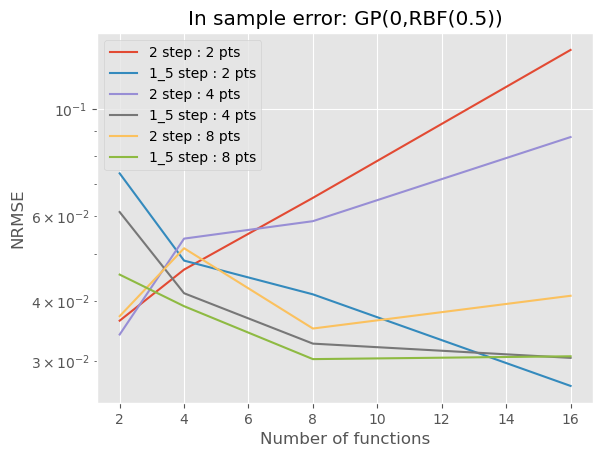

In [10]:
# In sample plot
plt.title('In sample error: GP(0,RBF(0.5))')
ms = NUM_FUN_LIST
OBS_PTS_LIST = [2,4,8]
for obs_pt in OBS_PTS_LIST:
    # 1_5 method
    mean_i_smpl_1_5 = jnp.array([jnp.mean(e) for e in jnp.array(err['1_5_mthd'][f'{obs_pt}_obs']['i_smpl'])])
    sd_i_smpl_1_5 = jnp.array([jnp.std(e) for e in jnp.array(err['1_5_mthd'][f'{obs_pt}_obs']['i_smpl'])])
    # 2 method
    mean_i_smpl_2 = jnp.array([jnp.mean(e) for e in jnp.array(err['2_mthd'][f'{obs_pt}_obs']['i_smpl'])])
    sd_i_smpl_2 = jnp.array([jnp.std(e) for e in jnp.array(err['2_mthd'][f'{obs_pt}_obs']['i_smpl'])])
    # Plot 2 method
    plt.plot(ms, mean_i_smpl_2, label = f'2 step : {obs_pt} pts')
    plt.fill_between(ms, mean_i_smpl_2 - sd_i_smpl_2, mean_i_smpl_2 + sd_i_smpl_2, alpha=.2)
    plt.yscale('log')
    # Plot 1_5 method
    plt.plot(ms, mean_i_smpl_1_5, label = f'1_5 step : {obs_pt} pts')
    plt.fill_between(ms, mean_i_smpl_1_5 - sd_i_smpl_1_5, mean_i_smpl_1_5 + sd_i_smpl_1_5, alpha=.2)
    plt.yscale('log')
plt.ylabel('NRMSE')
plt.xlabel('Number of functions')
plt.legend()
plt.show()

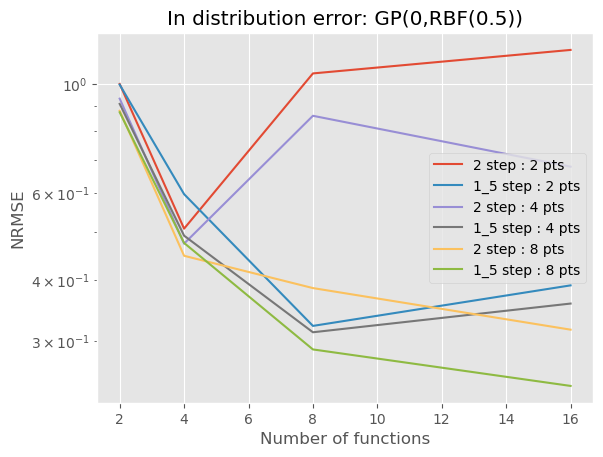

In [11]:
# In distribution plot
plt.title('In distribution error: GP(0,RBF(0.5))')
ms = NUM_FUN_LIST
OBS_PTS_LIST = [2,4,8]
for obs_pt in OBS_PTS_LIST:
    # 1_5 method
    mean_i_dis_1_5 = jnp.array([jnp.mean(e) for e in jnp.array(err['1_5_mthd'][f'{obs_pt}_obs']['i_dis'])])
    sd_i_dis_1_5 = jnp.array([jnp.std(e) for e in jnp.array(err['1_5_mthd'][f'{obs_pt}_obs']['i_dis'])])
    # 2 method
    mean_i_dis_2 = jnp.array([jnp.mean(e) for e in jnp.array(err['2_mthd'][f'{obs_pt}_obs']['i_dis'])])
    sd_i_dis_2 = jnp.array([jnp.std(e) for e in jnp.array(err['2_mthd'][f'{obs_pt}_obs']['i_dis'])])
    # Plot 2 method
    plt.plot(ms, mean_i_dis_2, label = f'2 step : {obs_pt} pts')
    plt.fill_between(ms, mean_i_dis_2 - sd_i_dis_2, mean_i_dis_2 + sd_i_dis_2, alpha=.2)
    plt.yscale('log')
    # Plot 1_5 method
    plt.plot(ms, mean_i_dis_1_5, label = f'1_5 step : {obs_pt} pts')
    plt.fill_between(ms, mean_i_dis_1_5 - sd_i_dis_1_5, mean_i_dis_1_5 + sd_i_dis_1_5, alpha=.2)
    plt.yscale('log')
plt.ylabel('NRMSE')
plt.xlabel('Number of functions')
plt.legend()
plt.show()

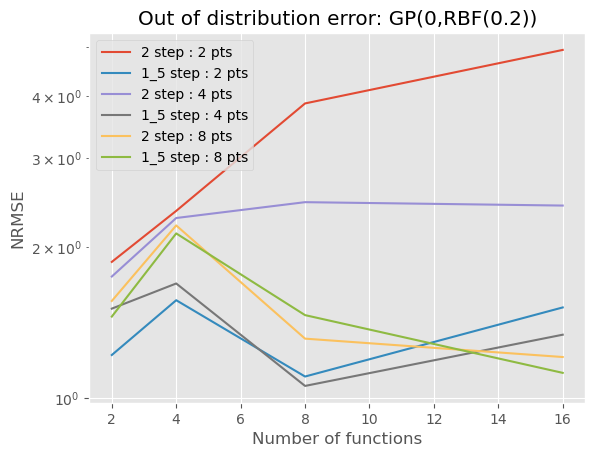

In [12]:
# Out of distribution
plt.title('Out of distribution error: GP(0,RBF(0.2))')
ms = NUM_FUN_LIST
OBS_PTS_LIST = [2,4,8]
for obs_pt in OBS_PTS_LIST:
    # 1_5 method
    mean_o_dis_1_5 = jnp.array([jnp.mean(e) for e in jnp.array(err['1_5_mthd'][f'{obs_pt}_obs']['o_dis'])])
    sd_o_dis_1_5 = jnp.array([jnp.std(e) for e in jnp.array(err['1_5_mthd'][f'{obs_pt}_obs']['o_dis'])])
    # 2 method
    mean_o_dis_2 = jnp.array([jnp.mean(e) for e in jnp.array(err['2_mthd'][f'{obs_pt}_obs']['o_dis'])])
    sd_o_dis_2 = jnp.array([jnp.std(e) for e in jnp.array(err['2_mthd'][f'{obs_pt}_obs']['o_dis'])])
    # Plot 2 method
    plt.plot(ms, mean_o_dis_2, label = f'2 step : {obs_pt} pts')
    plt.fill_between(ms, mean_o_dis_2 - sd_o_dis_2, mean_o_dis_2 + sd_o_dis_2, alpha=.2)
    plt.yscale('log')
    # Plot 1_5 method
    plt.plot(ms, mean_o_dis_1_5, label = f'1_5 step : {obs_pt} pts')
    plt.fill_between(ms, mean_o_dis_1_5 - sd_o_dis_1_5, mean_o_dis_1_5 + sd_o_dis_1_5, alpha=.2)
    plt.yscale('log')
plt.ylabel('NRMSE')
plt.xlabel('Number of functions')
plt.legend()
plt.show()